In [2]:
import torch
from torch import optim, nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.manifold import MDS
import matplotlib.pyplot as plt 

In [3]:
alexnet = models.alexnet(pretrained=True)
cuda0 = torch.device('cuda:0')
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
alexnet.classifier[4] = torch.nn.Linear(4096,1024)
alexnet.classifier[6] = torch.nn.Linear(1024,10)
alexnet.eval()

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Definining the dictionary which will store the extracted layers
activation = {}
alexnet.features[0].register_forward_hook(get_activation('conv1'))
alexnet.features[3].register_forward_hook(get_activation('conv2'))
alexnet.features[6].register_forward_hook(get_activation('conv3'))
alexnet.features[8].register_forward_hook(get_activation('conv4'))
alexnet.features[10].register_forward_hook(get_activation('conv5'))
alexnet.classifier[1].register_forward_hook(get_activation('fc6'))
alexnet.classifier[4].register_forward_hook(get_activation('fc7'))

activations = {}
layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7']
for filename in os.listdir("./Image Set"):
        #Open the images and transform them
        image = Image.open("./Image Set/"+filename)
        image = transform(image)
        #add batch dimension
        image = image.unsqueeze(0)
        #get the filename
        image_num = int(filename.split(".")[0])
        
        # Input the image into the model
        output = alexnet(image)
        
        # Loop through each layer and extract the activations
        for layer in layers:     
            if image_num not in activations:
                activations[image_num] = {}
            activations[image_num][layer] = activation[layer].view(1, -1)


In [5]:
#define a dict to store the rdm
rdm = {}
for layer in layers:
    #For each layer initalize a 156x156 matrix
    rdm[layer] = np.zeros((156, 156))
    for i in range(156):
        for j in range(156):
                #Get vector and get the distance between them
                v1 = activations[i+1][layer]  
                v2 = activations[j+1][layer]
                rdm[layer][i, j] = np.linalg.norm(v1 - v2)







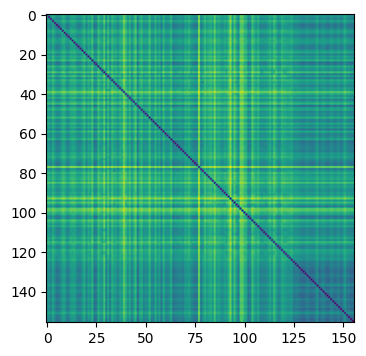

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


NameError: name 'pos1' is not defined

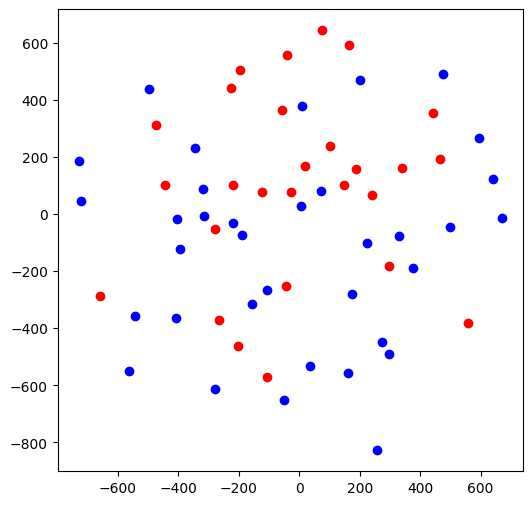

In [7]:
# Define the class labels
class_color = ['red','blue','green','yellow','purple']
lab=['Animals','Objects','Scenes','Human Activities','Faces']
# Loop through each layer and plot the RDM and MDS
for idx, layer in enumerate(rdm):
    # Plot the RDM
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(rdm[layer])
    plt.show()

    # Compute and Plot the MDS
    mds = MDS(n_components=2, dissimilarity='precomputed')
    pos = mds.fit_transform(rdm[layer])
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(pos[1:28, 0], pos[1:28, 1], c=class_color[0],label=lab[0])
    ax.scatter(pos[29:64, 0], pos[29:64, 1], c=class_color[1],label=lab[1])
    ax.scatter(pos[65:100, 0], pos[65:100, 1], c=class_color[2],label=lab[2])
    ax.scatter(pos[101:124, 0], pos[101:124, 1], c=class_color[3],label=lab[3])
    ax.scatter(pos[125:156, 0], pos[125:156, 1], c=class_color[4],label=lab[4])
    plt.legend()
    ax.set_title(f'{layer} MDS')
    plt.show()